## QuasarNET Performance vs SNR
#### Plot to show performance of QuasarNET as a function of SNR
xxx

In [2]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import fitsio
from astropy.io import fits
from astropy.table import Table, join
from keras.models import load_model
from quasarnet.io import read_data
from quasarnet.utils import process_preds, absorber_IGM, Wave
%matplotlib inline

from quasarnet.notebook_utils import *

from utils import *

Using TensorFlow backend.


In [3]:
qnet_path = '/global/homes/j/jfarr/Projects/QuasarNET/'
figsize = (12,12)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different QN models

In [8]:
## QN parameters
n_lines = 1
c_th = 0.8
include_cmax_qn = True

In [9]:
f_truth = qnet_path+'/data/truth_DR12Q.fits'
truth = read_truth([f_truth])

In [11]:
data = {}

## Load the VI data.
#f_sdrq = '/global/projecta/projectdirs/sdss/staging/dr12/boss/qso/DR12Q/Superset_DR12Q.fits'
#data['VI'] = load_sdrq_data(f_sdrq)

## Load the QN data.
f_qn = '../results/qn_results/qn_performance_vs_snr/qn_modelcoadd_testcoadd.fits'
data['QN_cc'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn)

## Load the QN data.
f_qn = '../results/qn_results/qn_performance_vs_snr/qn_modelsingexp_testcoadd.fits'
data['QN_sc'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn)

## Load the QN data.
f_qn = '../results/qn_results/qn_performance_vs_snr/qn_modelcoadd_testsingexp.fits'
data['QN_cs'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn)

## Load the QN data.
f_qn = '../results/qn_results/qn_performance_vs_snr/qn_modelsingexp_testsingexp.fits'
data['QN_ss'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn)

### Find the set of common targetids, and reduce all data to that set
This finds which targetids* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each targetid, and produces a single data table.

\* targetid = plate$\times$1000000000 + mjd$\times$10000 + fiber

In [12]:
data_table = reduce_data_to_table(data,truth,include_cmax_qn=include_cmax_qn)
data_table[:5]

INFO: 430653 common targetids


THING_ID,TARGETID,PLATE,MJD,FIBERID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_QN_cc,Z_QN_sc,Z_QN_cs,Z_QN_ss,CLASS_QN_cc,CLASS_QN_sc,CLASS_QN_cs,CLASS_QN_ss,ISQSO_QN_cc,ISQSO_QN_sc,ISQSO_QN_cs,ISQSO_QN_ss,CMAX_QN_cc,CMAX_QN_sc,CMAX_QN_cs,CMAX_QN_ss
int64,int64,int64,int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,str8,str8,str8,str8,bool,bool,bool,bool,float64,float64,float64,float64
87897905,3586551810016,3586,55181,16,2,2.242,QSO,True,2.244,2.238,2.260,2.242,QSO,QSO,QSO,QSO,True,True,True,True,1.000,1.000,1.000,1.000
87896919,3586551810032,3586,55181,32,2,0.000,STAR,False,2.366,2.167,2.143,0.647,NONQSO,NONQSO,NONQSO,NONQSO,False,False,False,False,0.000,0.000,0.000,0.001
87897024,3586551810036,3586,55181,36,2,0.000,STAR,False,2.108,2.124,2.087,2.093,NONQSO,NONQSO,NONQSO,NONQSO,False,False,False,False,0.000,0.000,0.000,0.000
94817272,3586551810038,3586,55181,38,2,2.196,QSO,True,2.204,2.198,2.202,2.181,QSO,QSO,QSO,QSO,True,True,True,True,1.000,1.000,1.000,1.000
87897405,3586551810040,3586,55181,40,2,0.000,STAR,False,2.112,2.121,2.093,1.687,NONQSO,NONQSO,NONQSO,NONQSO,False,False,False,False,0.000,0.000,0.000,0.000


In [13]:
# Include only objects in the data table that have the highest confidence level.
data_table = data_table[data_table['ZCONF_PERSON']==2]
len(data_table)

421414

### Compare the performance of the different model/data combos.
xxx

QN_cc
number of stars is 536
number of zerr is 693
number of classified QSOs is 237991
number of correctly classified QSOs is 236762

cth: [0.31 0.32 0.33 0.34]
pur: [0.99380637 0.99385615 0.99394346 0.99400145]
com: [0.99391701 0.99390018 0.99387073 0.99382867]

QN_sc
number of stars is 2014
number of zerr is 1975
number of classified QSOs is 241284
number of correctly classified QSOs is 237295

cth: [0.93 0.94 0.95 0.96]
pur: [0.9912776  0.99162395 0.99200826 0.99253819]
com: [0.99202396 0.99175894 0.99150653 0.99118261]

QN_cs
number of stars is 667
number of zerr is 2854
number of classified QSOs is 222304
number of correctly classified QSOs is 218783

cth: []
pur: []
com: []

QN_ss
number of stars is 3199
number of zerr is 4373
number of classified QSOs is 238423
number of correctly classified QSOs is 230851

cth: [0.49 0.5  0.51 0.52]
pur: [0.96798943 0.96824132 0.96851659 0.96886978]
com: [0.96844501 0.96832722 0.9681884  0.96807061]



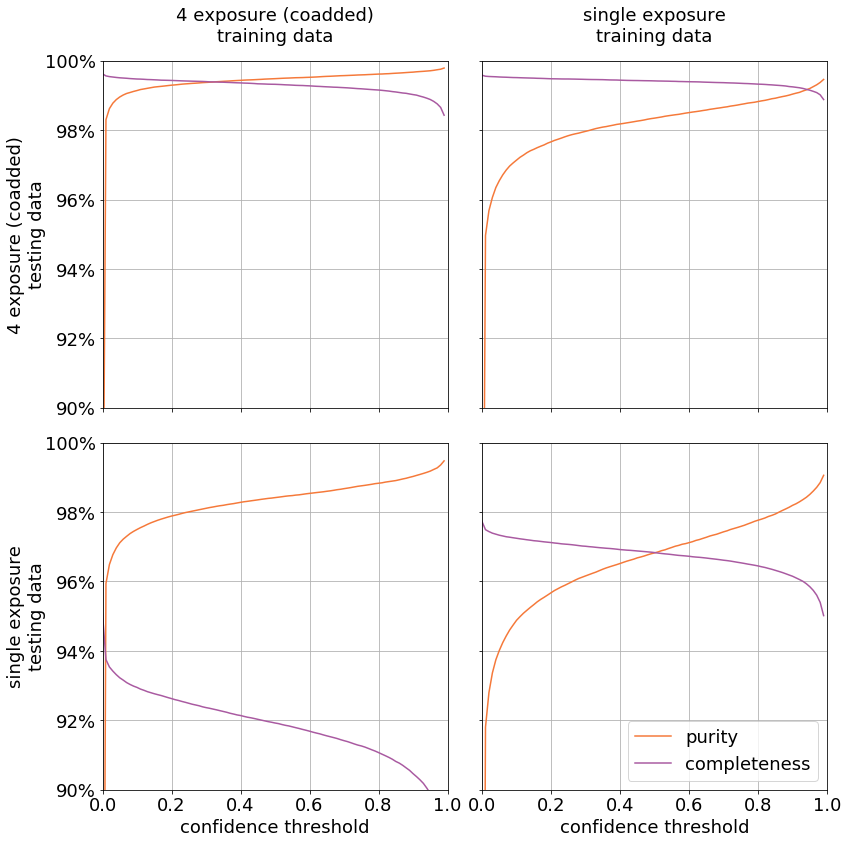

In [23]:
fig, axs = plt.subplots(2,2,figsize=(figsize[0],figsize[1]),sharex=True,sharey=True)

dv_max = 6000. #km/s

cth_min = 0.0
cth_max = 1.0
n_int = 100
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))
ndetect = 1

isqso_truth = (data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2))
isgal_truth = (data_table['CLASS_VI']=='GALAXY')
isstar_truth = (data_table['CLASS_VI']=='STAR')
isbad = ((data_table['CLASS_VI']=='BAD') | (data_table['ZCONF_PERSON']!=2))

for j,c in enumerate([k for k in data.keys() if 'QN' in k]):
    com = []
    pur = []
    
    z_c = data_table['Z_{}'.format(c)]
    zgood = (data_table['Z_VI']>0) & (abs(z_c-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.)
    
    for cth in c_th:
        isqso_c = (data_table['CMAX_{}'.format(c)]>cth)>=ndetect
                
        pur_num = (isqso_c & (isqso_truth | isgal_truth) & zgood & ~isbad).sum()
        pur_denom = (isqso_c & (~isbad)).sum()
        
        com_num = (isqso_c & zgood & isqso_truth).sum()
        com_denom = (isqso_truth).sum()
        
        pur += [pur_num/pur_denom]
        com += [com_num/com_denom]
        
        if cth==0.5:
            print(c)
            w_contaminants = isqso_c & isstar_truth
            w_zerr = isqso_c & (isqso_truth | isgal_truth) & (~zgood)
            print('number of stars is',w_contaminants.sum())
            print('number of zerr is',w_zerr.sum())
            print('number of classified QSOs is',pur_denom)
            print('number of correctly classified QSOs is',pur_num)
            print('')
            
    pur = np.array(pur)
    com = np.array(com)

    ind = np.where(pur>com)[0][0]
    print('cth:',c_th[ind-2:ind+2])
    print('pur:',pur[ind-2:ind+2])
    print('com:',com[ind-2:ind+2])
    print('')

    axs[j//2,j%2].plot(c_th,pur,label='purity',color=colours['C0'])
    axs[j//2,j%2].plot(c_th,com,label='completeness',color=colours['C1'])
    #axs[j//2,j%2].text(0.5,0.5,c,transform=axs[j//2,j%2].transAxes)
    
axs[0,0].text(-0.22,0.5,'4 exposure (coadded)\ntesting data',ha='center',va='center',
              transform=axs[0,0].transAxes,rotation=90)
axs[1,0].text(-0.22,0.5,'single exposure\ntesting data',ha='center',va='center',
              transform=axs[1,0].transAxes,rotation=90)
axs[0,0].text(0.5,1.1,'4 exposure (coadded)\ntraining data',ha='center',va='center',
              transform=axs[0,0].transAxes,rotation=0)
axs[0,1].text(0.5,1.1,'single exposure\ntraining data',ha='center',va='center',
              transform=axs[0,1].transAxes,rotation=0)

for i,ax in enumerate(axs.flatten()):
    if i//2==1:
        ax.set_xlabel(r'confidence threshold')
    ax.grid()
    ax.set_xlim(0.,1.)
    ax.set_ylim(0.9,1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))

axs[1,1].legend(loc=4)
plt.savefig('../plots/qn_performance_vs_snr.pdf')
plt.tight_layout()
fig.subplots_adjust(wspace=0.1,hspace=0.1)    
plt.show()